#Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import print_function
import numpy as np
import h5py
import time
import glob
import math
from sklearn.manifold import TSNE
from sklearn import metrics 
from keras.metrics import accuracy
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, Cropping2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D, AveragePooling1D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input, InputSpec)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics 
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

#Loading of data

In [80]:
df = pd.read_parquet('/content/drive/MyDrive/TB06_data/r206n05.gzip')


In [81]:
df.head()

,timestamp,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,...,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,label,New_label
index,,,,,,,,,,,,,,,,,,,,,
27,2020-06-01 00:15:00,21.353846,0.101026,21.8,20.8,30.076923,0.076923,31,30,29.0,...,3593600.0,0.0,3593600,3593600,4194240,0.0,4194240,4194240,0,0
30,2020-06-01 00:30:00,21.384615,0.189744,22.0,20.8,30.230769,0.192308,31,30,29.0,...,3593702.4,1228.8,3593728,3593664,4194240,0.0,4194240,4194240,0,0
33,2020-06-01 00:45:00,21.169231,0.078974,21.6,20.8,30.000000,0.000000,30,30,29.0,...,3593792.0,0.0,3593792,3593792,4194240,0.0,4194240,4194240,0,0
36,2020-06-01 01:00:00,21.615385,0.083077,22.0,21.0,30.384615,0.256410,31,30,29.0,...,3593920.0,0.0,3593920,3593920,4194240,0.0,4194240,4194240,0,0
39,2020-06-01 01:15:00,21.153846,0.174359,21.8,20.6,30.000000,0.000000,30,30,29.0,...,3593984.0,0.0,3593984,3593984,4194240,0.0,4194240,4194240,0,0


In [82]:
df = df.drop(['label','timestamp'],axis=1)

In [83]:
df.describe()


,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
count,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,...,15310.000000,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,15310.000000
mean,18.716309,0.041324,18.940888,18.489288,27.082400,0.073318,27.264533,26.897257,27.616306,0.062888,...,2461.721816,3.586335e+06,5.954080e+08,3.587052e+06,3.585617e+06,4194240.0,0.0,4194240.0,4194240.0,0.049510
std,2.482816,0.097875,2.505538,2.466572,2.421890,0.142473,2.452004,2.409420,2.378890,0.161412,...,554.162798,4.641056e+05,2.908237e+10,4.617490e+05,4.674183e+05,0.0,0.0,0.0,0.0,0.310766
min,10.426667,0.000000,10.600000,10.000000,20.266667,0.000000,21.000000,20.000000,20.000000,0.000000,...,1235.000000,7.561143e+03,0.000000e+00,1.664000e+04,0.000000e+00,4194240.0,0.0,4194240.0,4194240.0,0.000000
25%,16.986667,0.008381,17.200000,16.800000,25.000000,0.000000,25.000000,25.000000,26.000000,0.000000,...,2093.000000,3.279424e+06,0.000000e+00,3.279424e+06,3.279424e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
50%,18.586667,0.014095,18.800000,18.400000,27.000000,0.000000,27.000000,27.000000,28.000000,0.000000,...,2240.500000,3.600128e+06,0.000000e+00,3.600128e+06,3.600128e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
75%,20.613333,0.036952,21.000000,20.200000,29.000000,0.123810,29.000000,29.000000,29.000000,0.066667,...,2698.000000,4.194240e+06,0.000000e+00,4.194240e+06,4.194240e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
max,25.226667,4.300952,25.400000,25.200000,33.000000,4.409524,33.000000,33.000000,33.933333,8.638095,...,3804.000000,4.194240e+06,1.835336e+12,4.194240e+06,4.194240e+06,4194240.0,0.0,4194240.0,4194240.0,2.000000


In [84]:
df.isna().any()


avg:ambient       False
var:ambient       False
max:ambient       False
min:ambient       False
avg:dimm0_temp    False
                  ...  
avg:swap_total    False
var:swap_total    False
max:swap_total    False
min:swap_total    False
New_label         False
Length: 461, dtype: bool

In [85]:
df.isnull().sum()


avg:ambient       0
var:ambient       0
max:ambient       0
min:ambient       0
avg:dimm0_temp    0
                 ..
avg:swap_total    0
var:swap_total    0
max:swap_total    0
min:swap_total    0
New_label         0
Length: 461, dtype: int64

In [86]:
X = df.drop('New_label',axis=1)
y = df.New_label

In [87]:
y

index
27       0
30       0
33       0
36       0
39       0
        ..
96180    0
96183    0
96186    0
96189    0
96192    0
Name: New_label, Length: 15310, dtype: int64

In [88]:
y = y.apply(lambda x: 1 if x == 2 else 0)


In [89]:
y[y==1]

index
3015     1
3018     1
3021     1
3024     1
3027     1
        ..
95211    1
95214    1
95217    1
95220    1
95223    1
Name: New_label, Length: 379, dtype: int64

In [90]:
a, b=y.value_counts()

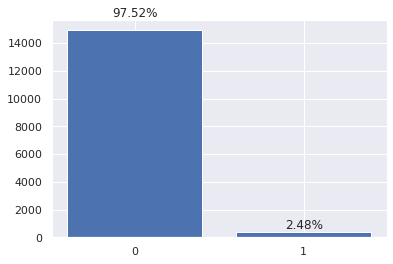

In [91]:
a_perc = round((a / y.value_counts().sum()) * 100, 2)
b_perc= round((b / y.value_counts().sum()) * 100, 2)
bar_label=[str(a_perc)+'%', str(b_perc)+'%']

fig, ax = plt.subplots()
bar_tick_label=['0','1']
bar_plot = plt.bar(y.unique(), y.value_counts(), tick_label=bar_tick_label)
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

In [92]:
X.shape

(15310, 460)

In [93]:
from sklearn.preprocessing import MinMaxScaler

columns = list(X.columns.values)
scaler = MinMaxScaler() 
X[columns] = scaler.fit_transform(X[columns])
X.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total
index,,,,,,,,,,,,,,,,,,,,,
27,0.738323,0.023489,0.756757,0.710526,0.770439,0.017445,0.833333,0.769231,0.645933,0.0,...,0.304531,0.309848,0.856535,0.000000e+00,0.856224,0.856794,0.0,0.0,0.0,0.0
30,0.740402,0.044117,0.770270,0.710526,0.782521,0.043612,0.833333,0.769231,0.645933,0.0,...,0.306068,0.309848,0.856560,6.695233e-10,0.856254,0.856809,0.0,0.0,0.0,0.0
33,0.725849,0.018362,0.743243,0.710526,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,...,0.304531,0.310237,0.856581,0.000000e+00,0.856270,0.856840,0.0,0.0,0.0,0.0
36,0.755994,0.019316,0.770270,0.723684,0.794603,0.058149,0.833333,0.769231,0.645933,0.0,...,0.306068,0.310627,0.856612,0.000000e+00,0.856300,0.856870,0.0,0.0,0.0,0.0
39,0.724809,0.040540,0.756757,0.697368,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,...,0.305300,0.308680,0.856627,0.000000e+00,0.856316,0.856886,0.0,0.0,0.0,0.0


In [94]:
X.shape


(15310, 460)

In [95]:
y.shape

(15310,)

#Autoencoder Model

In [96]:
X = np.expand_dims(X, axis=2)

In [97]:
X.shape

(15310, 460, 1)

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

##Autoencoder

In [99]:
def model():
  # Conv1 #
  input_img = Input(shape=(460, 1, 1))  
  x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
  x=BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

  # Conv2 #
  x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
  x=BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

  # Conv 3 #
  x = Conv2D(filters = 8, kernel_size =(3, 3), activation='relu', padding='same')(x)
  x=BatchNormalization()(x)
  encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

  
  # shape_before_flattening = encoded.get_output_at(0).get_shape().as_list()
  # x = Flatten()(encoded)
  # #Embedded latent space: 14 dimensions (features)
  # encoded = Dense(latent_dim, activation=activation, name='encoded')(x)
  encoded = Flatten()(encoded)
  encoded = Dense(460, activation='softmax')(encoded)

  # Note:
  # padding is a hyper-parameter for either 'valid' or 'same'. 
  # "valid" means "no padding". 
  # "same" results in padding the input such that the output has the same length as the original input.
  ############
  # Decoding #
  ############

  # DeConv1
  # d = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(encoded)
  # d = Reshape(shape_before_flattening[1:])(d)
  x = Reshape((460,1,1))(encoded)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x=BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)

  # DeConv2
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x=BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)

  # Deconv3
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x=BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
  decoded = Flatten()(decoded)
  decoded = Dense(460, activation='softmax')(decoded)

  autoencoder = Model(input_img, decoded)
  encoder =Model(input_img, encoded)

  return autoencoder, encoder

In [100]:
Pre_train_optimizer_adam = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-5)
Pre_train_optimizer_sgd = SGD(learning_rate=0.1, momentum=0.9)
activation = 'relu'
# ReLU initial weights
kernel_initializer='glorot_uniform'
latent_dim = 14


In [101]:
autoencoder, encoder=model()
autoencoder.compile(optimizer=Pre_train_optimizer_adam, loss='mse')

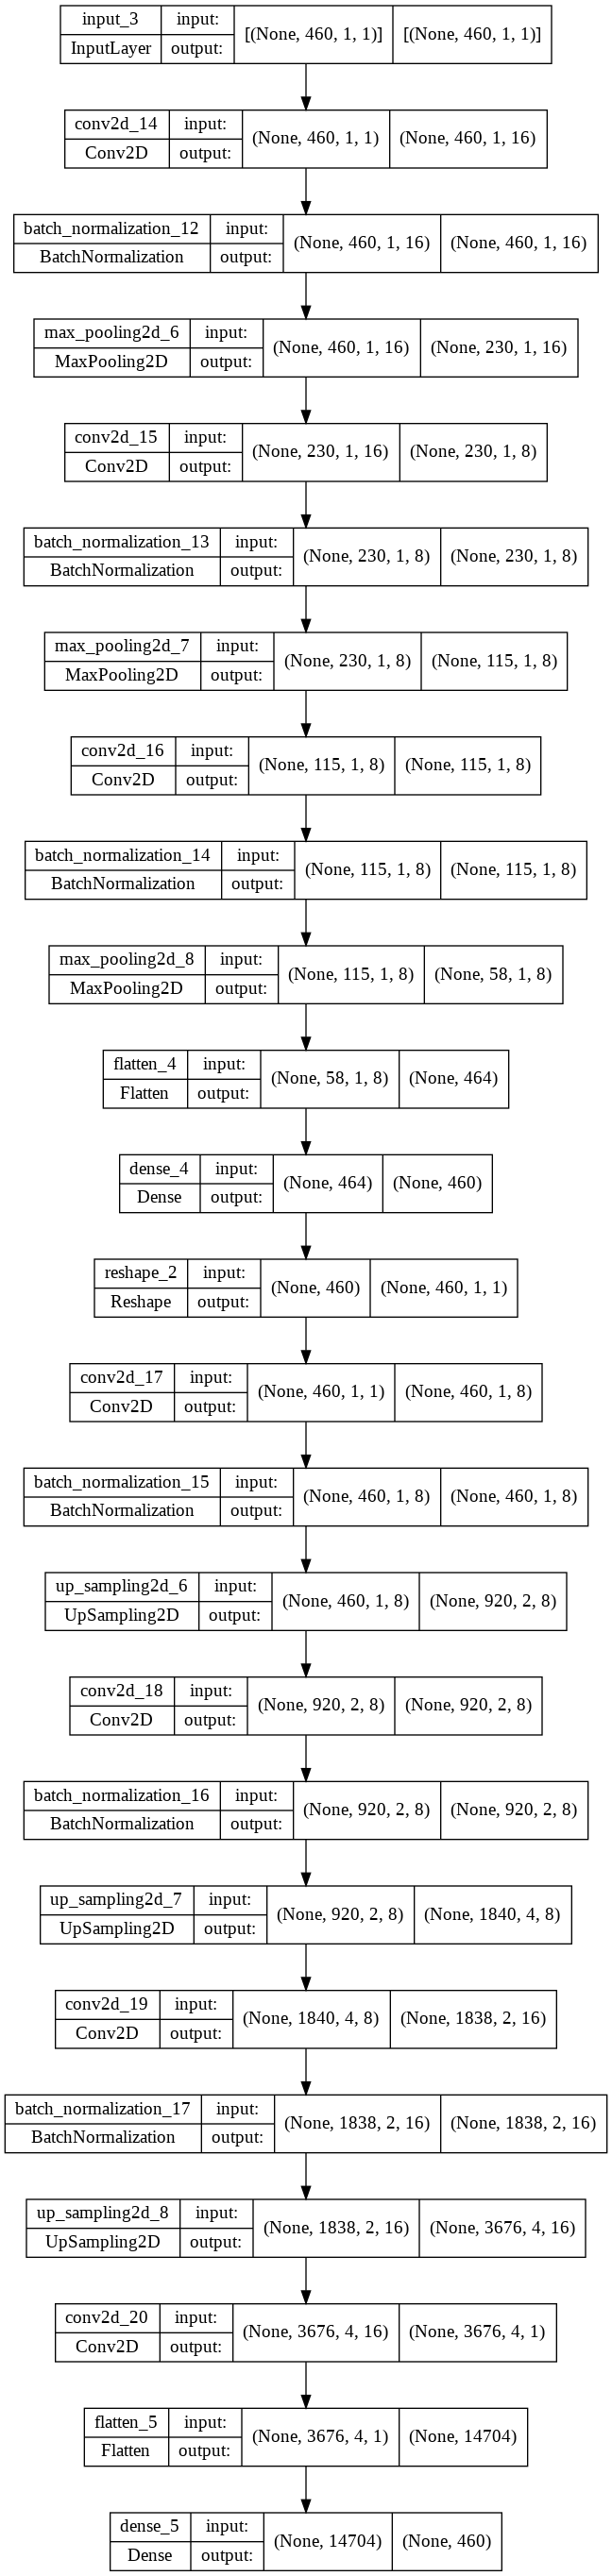

In [102]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image

Image(filename='autoencoder.png')

In [103]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 460, 1, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 460, 1, 16)        160       
                                                                 
 batch_normalization_12 (Bat  (None, 460, 1, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 230, 1, 16)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 230, 1, 8)         1160      
                                                                 
 batch_normalization_13 (Bat  (None, 230, 1, 8)        32  

##Hyperparameters tuning

At the end of the evaluation, all results will be stored in a dictionary converted into dataFrame

In [104]:
dict_info = {'Hyperparameters':[], 'Accuracy (%)': [], 'Silhouette Score': [],'NMI': []}

In [105]:
e = 100 #@param [100, 500, 1000] {type:"raw"}
bs= 256#@param [64, 128, 256] {type:"raw"}
v_bs= 128 #@param [64, 128, 256] {type:"raw"}

In [106]:
from keras.callbacks import TensorBoard
path = '/content/drive/MyDrive/TB06_data/results'
history=autoencoder.fit(X_train, X_train,
                epochs=e,
                batch_size=bs,
                verbose=1,
                shuffle=True,
                validation_batch_size=v_bs,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
                



Epoch 1/100
42/42 [==============================] - 8s 125ms/step - loss: 0.1719 - val_loss: 0.1725
Epoch 2/100
42/42 [==============================] - 4s 87ms/step - loss: 0.1714 - val_loss: 0.1725
Epoch 3/100
42/42 [==============================] - 4s 89ms/step - loss: 0.1709 - val_loss: 0.1725
Epoch 4/100
42/42 [==============================] - 4s 87ms/step - loss: 0.1702 - val_loss: 0.1724
Epoch 5/100
42/42 [==============================] - 4s 89ms/step - loss: 0.1700 - val_loss: 0.1724
Epoch 6/100
42/42 [==============================] - 4s 89ms/step - loss: 0.1700 - val_loss: 0.1724
Epoch 7/100
42/42 [==============================] - 4s 89ms/step - loss: 0.1698 - val_loss: 0.1724
Epoch 8/100
42/42 [==============================] - 4s 89ms/step - loss: 0.1697 - val_loss: 0.1724
Epoch 9/100
42/42 [==============================] - 4s 88ms/step - loss: 0.1697 - val_loss: 0.1724
Epoch 10/100
42/42 [==============================] - 4s 87ms/step - loss: 0.1697 - val_loss: 0.172

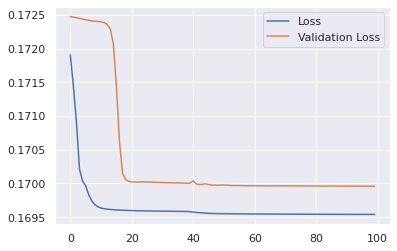

In [107]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [108]:
autoencoder.save_weights(path + '/ae_weights_conv.h5')


In [109]:
autoencoder.load_weights('/content/drive/MyDrive/TB06_data/results/ae_weights_conv.h5')


#DBC

In [110]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        #self.input_spec = InputSpec(ndim=4)
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        #assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
          
        """
        #inputs=tf.reshape(inputs, [-1, 58])
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [111]:
def target_distribution(q):
    """
    Compute the target distribution p, given soft assignements, q. The target distribtuion is generated by giving
    more weight to 'high confidence' samples - those with a higher probability of being a signed to a certain cluster. 
    This is used in the KL-divergence loss function.
    # Arguments
        q: Soft assignement probabilities - Probabilities of each sample being assigned to each cluster.
    # Input:
         2D tensor of shape [n_samples, n_features].
    # Output:
         2D tensor of shape [n_samples, n_features].
    """
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [112]:
autoencoder, encoder = model()
autoencoder.load_weights(path + '/ae_weights_conv.h5')

clustering_layer = ClusteringLayer(n_clusters=2, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[autoencoder.output, clustering_layer])

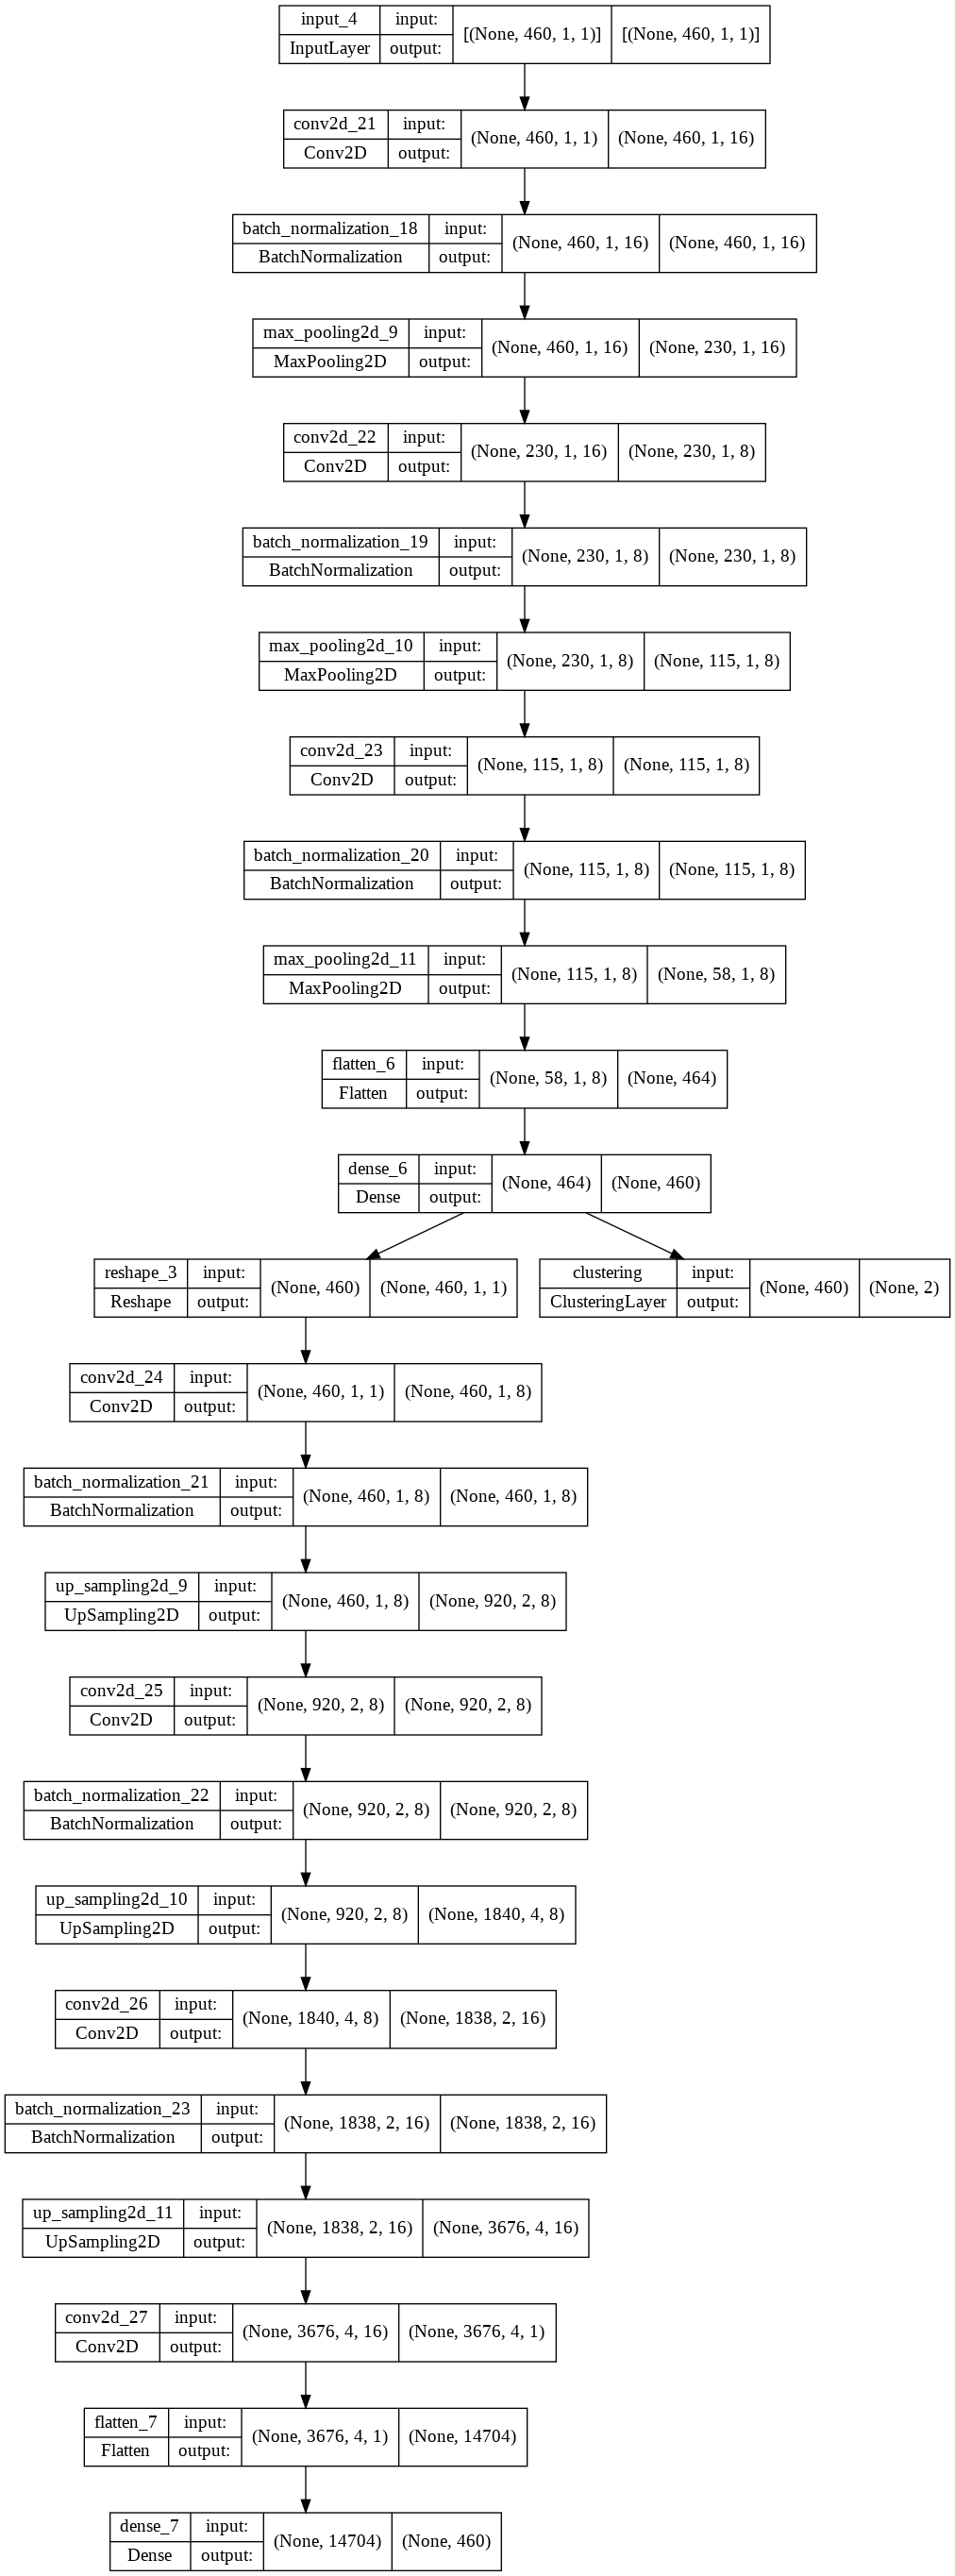

In [113]:
plot_model(model, show_shapes=True)


In [114]:
X_train_exp=np.expand_dims(X_train,axis=2)

In [115]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X_train_exp))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [116]:
np.unique(y_pred)

array([0, 1], dtype=int32)

In [117]:
np.unique(y_pred)

array([0, 1], dtype=int32)

In [118]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=Pre_train_optimizer_adam)
model.save_weights(path + '/conv_b_DBC_model_final.h5')


In [119]:
np.unique(y_pred)

array([0, 1], dtype=int32)

##DBC training

In [120]:
index_array = np.arange(X_train_exp.shape[0])
index = 0
maxiter = 1000
update_interval = 100
tol = 0.1
loss=0
tic = time.time()

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(X_train_exp, verbose=1)
        # update the auxiliary target distribution p
        p = target_distribution(q)  

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        #print('Values of y_pred:\n')
        #print(y_pred)
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)


        #loss= np.round(loss, 5) # Round the loss 
        print('Iter %d' % ite)
        print('Loss: {}'.format(loss))

        # Break training if loss reaches the tolerance threshhold
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break
    idx = index_array[index * bs: min((index+1) * bs, X_train_exp.shape[0])]
    loss = model.train_on_batch(x=X_train_exp[idx], y=[p[idx], X_train_exp[idx]])
    index = index + 1 if (index + 1) * bs <= X_train_exp.shape[0] else 0


#Save model and model weights seperately
model.save_weights('./DBC_model_final.h5')
model.save('Saved_DBC_model.hdf5')

toc = time.time()
print('DBC execution Time : {0:4.1f} seconds'.format((toc-tic)))

335/335 [==============================] - 1s 4ms/step
Iter 0
Loss: 0
335/335 [==============================] - 1s 4ms/step
Iter 100
Loss: [0.14217248558998108, 0.009277240373194218, 0.14124475419521332]
delta_label  0.0 < tol  0.1
DBC execution Time : 18.9 seconds


In [121]:
X_test.shape

(4593, 460, 1)

In [122]:
model.load_weights('/content/drive/MyDrive/TB06_data/results/conv_b_DBC_model_final.h5')
q, _ = model.predict(np.expand_dims(X_test, axis=2), verbose=1)
p = target_distribution(q)  # update the auxiliary target distribution p
y_pred=q.argmax(1)

144/144 [==============================] - 1s 4ms/step


In [123]:
np.unique(y_pred)

array([0, 1], dtype=int32)

#Visualization

##PCA -  2 components

In [124]:
# pca_2 = PCA(n_components = 2)
# prin_comp = pca_2.fit_transform(y_pred)
# pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2'])

In [125]:
# pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
# pca_df.head()

In [126]:
# plt.figure(figsize = (10, 10))
# ax = sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red', 'blue'] )
# ax.tick_params(axis='both', which='major', labelsize = 15)
# plt.xlabel('pca1', fontsize=18)
# plt.ylabel('pca2', fontsize=16)

In [127]:
# print('Cumulative explained variation for 2 principal components: {}'.format(np.sum(pca_2.explained_variance_ratio_)))

##PCA - 3 components 

In [128]:
# pca_3d = PCA(n_components = 3)
# prin_comp = pca_3d.fit_transform(pred)
# pca_df_3d = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])

In [129]:
# pca_df_3d = pd.concat([pca_df_3d, pd.DataFrame({'cluster': labels})], axis = 1)
# pca_df_3d.head()

In [130]:
# ex_variance=np.var(prin_comp,axis=0)
# ex_variance_ratio = ex_variance/np.sum(ex_variance)
# ex_variance_ratio


# Xax = prin_comp[:,0]
# Yax = prin_comp[:,1]
# Zax = prin_comp[:,2]

# cdict = {0:'red',1:'blue'}
# labl = {0:'0', 1:'1'}
# marker = {0:'*',1:'o'}
# alpha = {0:.3, 1:.5}

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# fig.patch.set_facecolor('white')
# for l in np.unique(y_test):
#  ix=np.where(y_test==l)
#  ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
#            label=labl[l], marker=marker[l], alpha=alpha[l])
# # for loop ends
# ax.set_xlabel("pca1", fontsize=14)
# ax.set_ylabel("pca2", fontsize=14)
# ax.set_zlabel("pca3", fontsize=14)

# ax.legend()
# plt.show()


##TSNE

In [155]:
X_train.shape

(10717, 460, 1)

In [156]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=250)
tsne_results = tsne.fit_transform(X_train.reshape(10717, 460))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10717 samples in 0.004s...
[t-SNE] Computed neighbors for 10717 samples in 3.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10717
[t-SNE] Computed conditional probabilities for sample 2000 / 10717
[t-SNE] Computed conditional probabilities for sample 3000 / 10717
[t-SNE] Computed conditional probabilities for sample 4000 / 10717
[t-SNE] Computed conditional probabilities for sample 5000 / 10717
[t-SNE] Computed conditional probabilities for sample 6000 / 10717
[t-SNE] Computed conditional probabilities for sample 7000 / 10717
[t-SNE] Computed conditional probabilities for sample 8000 / 10717
[t-SNE] Computed conditional probabilities for sample 9000 / 10717
[t-SNE] Computed conditional probabilities for sample 10000 / 10717
[t-SNE] Computed conditional probabilities for sample 10717 / 10717
[t-SNE] Mean sigma: 0.347084
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.353607
[t-SNE] KL 

      tsne1     tsne2  cluster
0  2.000176 -6.404800        1
1  0.127670  5.935914        1
2 -0.181680  0.770471        1
3  2.843488  8.048431        0
4  1.979102 -6.416256        1




Text(0, 0.5, 'tsne2')

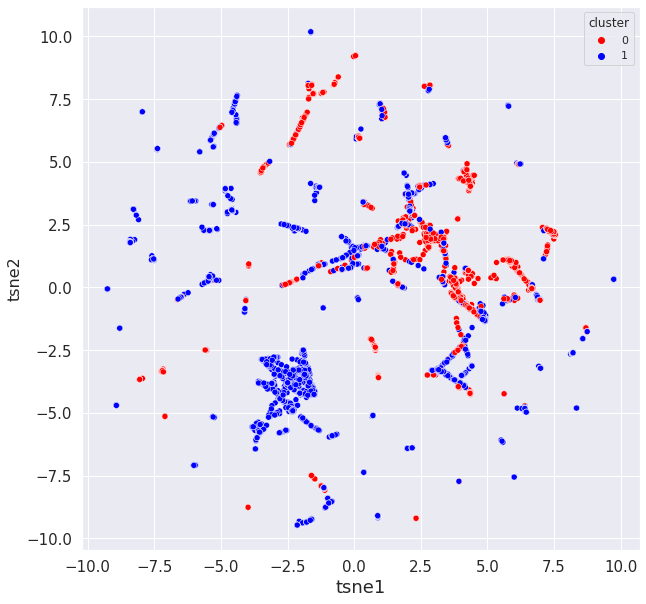

In [182]:
tsne_df = pd.DataFrame(data = tsne_results, columns = ['tsne1', 'tsne2'])
tsne_df = pd.concat([tsne_df, pd.DataFrame({'cluster': kmeans.labels_})], axis = 1)
print(tsne_df.head())
print('\n')
vis_x = tsne_results[:, 0]
vis_y = tsne_results[:, 1]
plt.figure(figsize = (10, 10))
ax = sns.scatterplot(x = vis_x, y = vis_y, hue = 'cluster', data = tsne_df, palette = ['red', 'blue'] )
ax.tick_params(axis='both', which='major', labelsize = 15)
plt.xlabel('tsne1', fontsize=18)
plt.ylabel('tsne2', fontsize=16)

#Evaluation

##Accuracy

In [133]:
y_test=np.array(y_test)

In [134]:
from scipy.optimize import linear_sum_assignment

y_true = y_train.values.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    #print(y_pred[i])
    w[y_pred[i], y_true[i]] += 1
ind = linear_sum_assignment(-w)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size*100


In [135]:
print('The accuracy of the model is {0:,.2f}%'.format(acc))

The accuracy of the model is 59.10%


##Silhouette_score

In [136]:
from sklearn.metrics import  normalized_mutual_info_score, adjusted_rand_score, silhouette_score, silhouette_samples

score = silhouette_score(X_train.reshape(10717,460*1), y_pred, metric='euclidean')
print ("For n_clusters = 2, Deep clustering silhouette score is {})".format(score))

For n_clusters = 2, Deep clustering silhouette score is 0.03444673135428668)


In [137]:
from utils import plot_silhouette

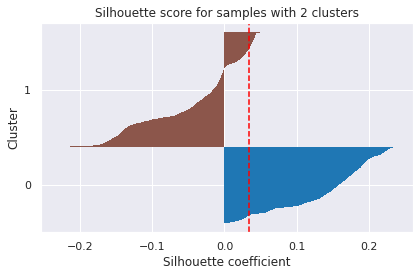

In [138]:
cluster_labels = np.unique(kmeans.labels_)
n_clusters = cluster_labels.shape[0] 
# Compute the Silhouette Coefficient for each sample, with the euclidean metric
silhouette_score_samples = silhouette_samples(X_train.reshape(10717,460*1), y_pred, metric='euclidean')
plt.title('Silhouette score for samples with {} clusters'.format(2))
plot_silhouette(silhouette_score_samples, kmeans.labels_)

This slhouette score means that the point is on average closer to points in another cluster than to points in its own cluster.

##Normalized_mutual_info_score

In [139]:
from numpy.lib.function_base import average
nmi=normalized_mutual_info_score(y_true, y_pred, average_method='geometric')
print(nmi)


0.0026508316900411286


##Results

In [140]:
dict_info['Hyperparameters'].append('Parameters:  {}, {}, {}'.format(e, bs, v_bs))
dict_info['Accuracy (%)'].append(acc)
dict_info['Silhouette Score'].append(score)
dict_info['NMI'].append(nmi)

In [141]:
dfData = pd.DataFrame(dict_info)
dfData

,Hyperparameters,Accuracy (%),Silhouette Score,NMI
0,"Parameters: 100, 256, 128",59.102361,0.034447,0.002651


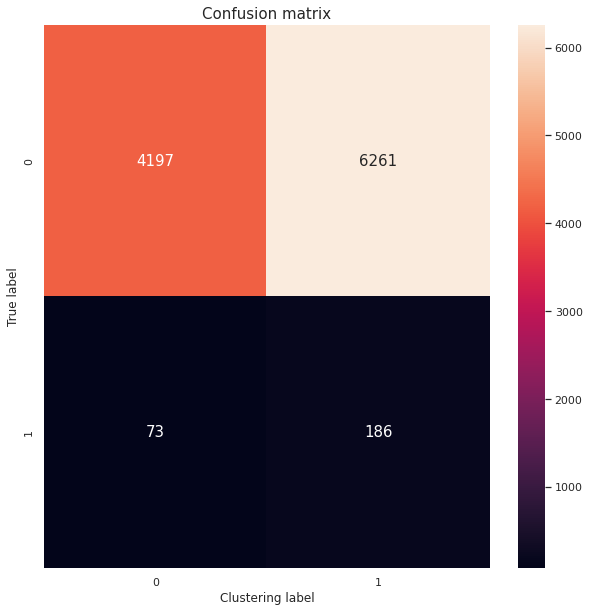

In [142]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=1)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 15});
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Clustering label', fontsize=12)
plt.show()